## Regression_problem
    1. Data
        1.1 EDA
            1.1.1 check_numeric
                1.1.1.1 if not numeric -> encoding
            1.1.2 check_null
                1.1.2.1 if null -> mean_fill, mode_fill, front_fill, back_fill, 
            1.1.3 check_outlier
                1.1.3.1 if outlier -> drop outlier
    2. Preprocessing
        2.1 if dataframe
            2.1.1 dataframe -> array
        2.2 data_spilit
            - tot_data -> modeling_data, test_data
            - modeling_data -> train_data, validate_data
        2.3 scaling 
            2.3.1 minmaxscaling
            2.3.2 standardscaling
    3. Modelling
        3.1 gridsearch
        3.2 randomsearch
    

In [1]:
# librarys
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd 
from sklearn.datasets import fetch_california_housing

In [2]:
raw_data = fetch_california_housing()

# raw_data to arr
data_arr = raw_data['data']
target_arr = raw_data['target']

# raw_data to df
data_df=pd.DataFrame(data_arr, columns = raw_data['feature_names'])
data_df.name = 'data_df'

target_df=pd.DataFrame(target_arr,columns= ['target'])
target_df.name = 'target_df'

In [3]:
# 1.1.1 check_numeric
#   1.1.1.1 if not numeric -> encoding
print(data_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB
None


In [4]:
# 1.1.2 check_null
#   1.1.2.1 if null -> mean_fill, mode_fill, front_fill, back_fill, 
print(data_df.isna().sum())

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64


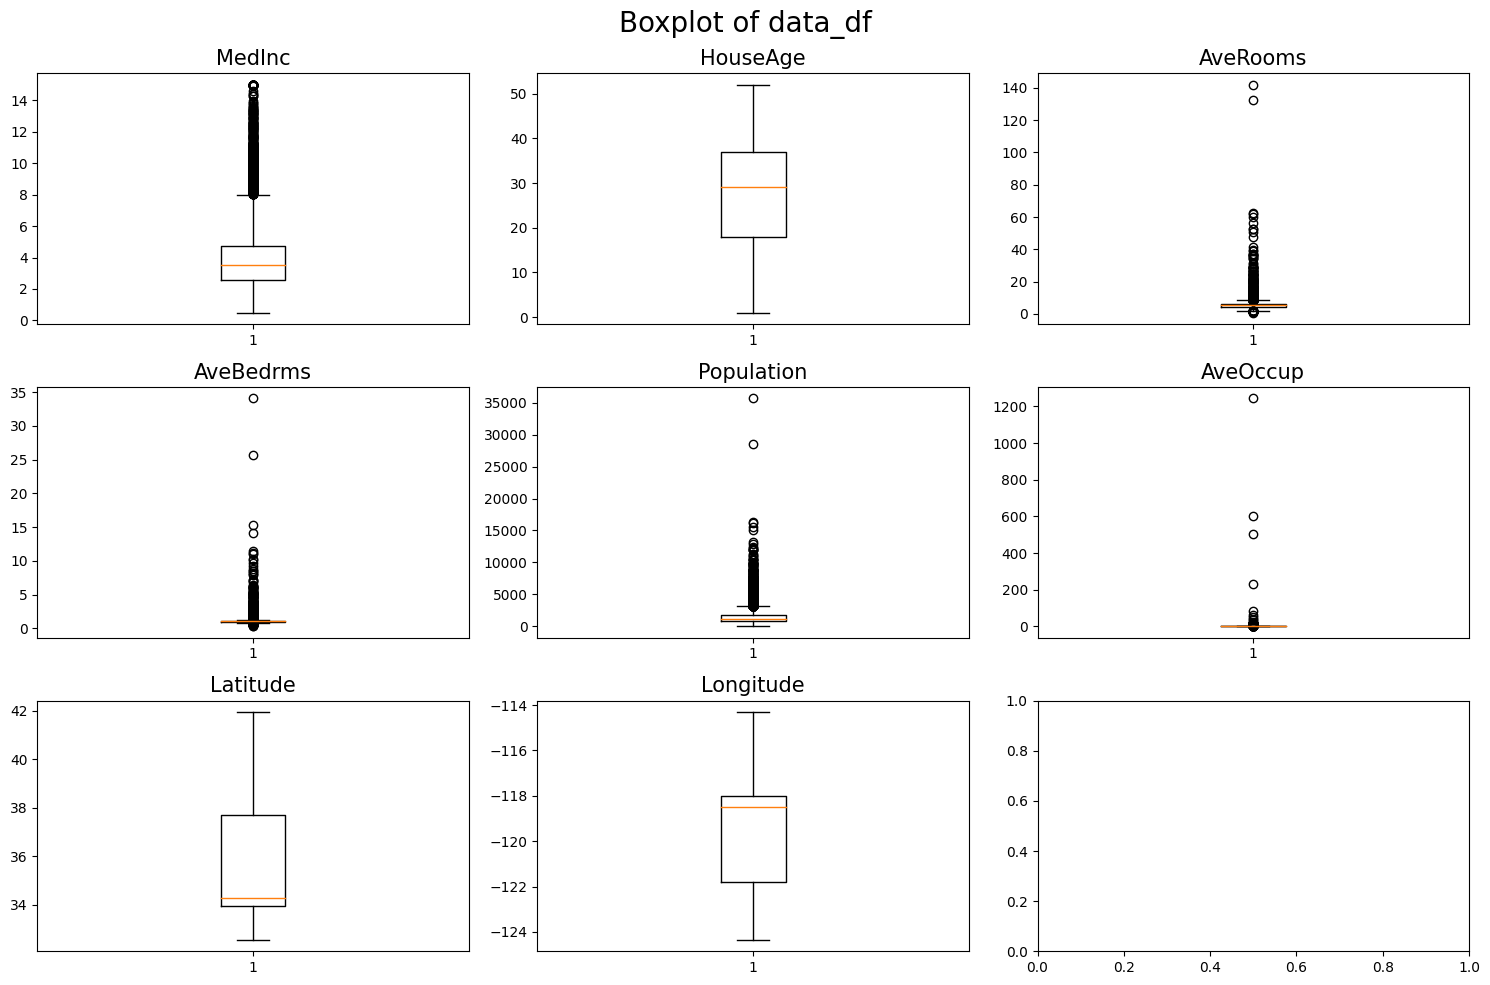

In [5]:
# 1.1.3 check_outlier
#   1.1.3.1 if outlier -> drop outlier

# 1_draw_boxplot
def draw_boxplot(dataframe,width=10,height=10):
    df_len = len(dataframe.columns)
    _n=round(np.sqrt(df_len))
    fig,axes=plt.subplots(_n,_n)
    fig.set_figheight(height)
    fig.set_figwidth(width)
    for i in range(_n):
        for j in range(_n):
            try:
                data = dataframe.iloc[:,i*_n+j]
                axes[i,j].boxplot(data)
                axes[i,j].set_title(data.name,fontsize=15)
            except IndexError:
                pass
    plt.suptitle("Boxplot of {}".format(dataframe.name), fontsize=20)
    plt.tight_layout()
    plt.show()
    return None

draw_boxplot(data_df,width=15,height=10)

In [6]:
# out_lier cut
def cut_high(data,percent):
    high_percent=100 - percent
    high_lim=np.percentile(data,high_percent)
    idx = data[high_lim < data].index
    return idx.tolist()

def cut_low(data,percent):
    low_percent = percent
    low_lim=np.percentile(data,low_percent)
    idx = data[data < low_lim].index
    return idx.tolist()

def cut_both(data,percent):
    high_percent=100 - percent
    high_lim=np.percentile(data,high_percent)
    high_idx = data[high_lim < data].index
    
    low_percent = percent
    low_lim=np.percentile(data,low_percent)
    low_idx = data[data < low_lim].index
    
    idx = high_idx.append(low_idx)
    return idx.tolist()

In [7]:
cut_idx = list()
for column in ['AveRooms', 'AveBedrms', 'Population', 'AveOccup']:
    cut_idx.append(cut_high(data_df[column],0.05))
cut_idx=np.array(cut_idx).ravel()
cut_idx=np.unique(cut_idx)

data_df.drop(cut_idx,inplace=True)
target_df.drop(cut_idx,inplace=True)

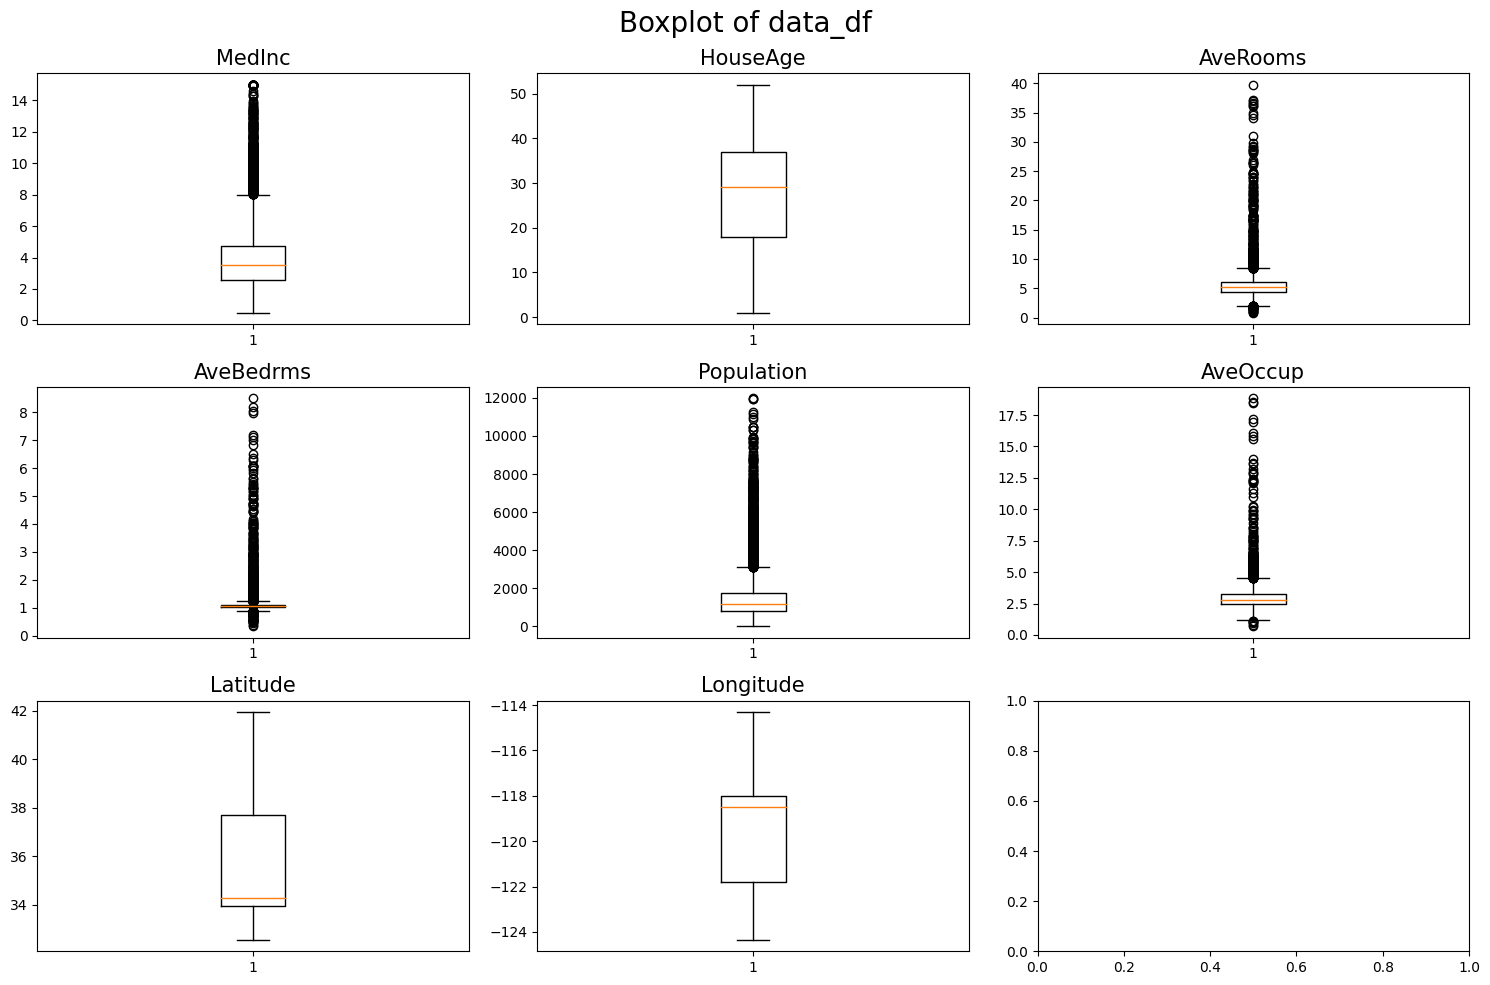

In [8]:
draw_boxplot(data_df,width=15,height=10)

### 3. Preprocessing

In [9]:
data_arr=data_df.to_numpy()
target_arr=target_df.to_numpy()

from sklearn.model_selection import train_test_split

x_modeling,x_test,y_modeling,y_test = train_test_split(data_arr,target_arr,test_size=0.1,
                                                       random_state=42)
x_train,x_val,y_train,y_val = train_test_split(x_modeling,y_modeling,test_size=0.3,
                                               random_state=42)

In [10]:
from sklearn.preprocessing import StandardScaler

ssc = StandardScaler()
ssc.fit(x_train)

x_train_ssc = ssc.transform(x_train)
x_val_ssc = ssc.transform(x_val)

## 4. modeling

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
lr = LinearRegression()
dtr = DecisionTreeRegressor()

In [12]:
dtr.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [17]:
# 1_gridsearchcv
from sklearn.model_selection import GridSearchCV,KFold

param_grid = {
    "ccp_alpha":[0.0,0.01,0.02],
    "min_samples_leaf":[1,2,3],
    "min_samples_split":[2,3,4]
}

kfold = KFold(n_splits=5,shuffle=True)

grid_cv = GridSearchCV(estimator=dtr,
                       param_grid=param_grid,
                       n_jobs=-1,
                       verbose=1,
                       cv=kfold)
grid_cv.fit(x_train_ssc,y_train)

grid_cv_best=grid_cv.best_estimator_

In [21]:
# 2_randomcv
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    "ccp_alpha":[0.0,0.01,0.02],
    "min_samples_leaf":[1,2,3,4,5],
    "min_samples_split":[2,3,4,5,6]
}

rand_cv=RandomizedSearchCV(estimator=dtr,
                           param_distributions=param_dist,
                           n_iter=50,
                           cv=kfold
                           )
rand_cv.fit(x_train_ssc,y_train)
rand_cv_best = rand_cv.best_estimator_